In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set(font_scale=1.5)
sbn.set_style('white')
import os

%matplotlib inline

# MIT Webserver Processing

Due to the 250bp limitation of the http://crispr.mit.edu/ website we uploaded 250 bp segments with 50 bp overlaps. Using the batch-mode submission the results were exported as a set of Genbank files in which the potential gRNAs are encoded as sequence features. These files are compressed in the `data/MITData.tar.gz` file.

In [2]:
import tarfile
from Bio import SeqIO
import re

reg = re.compile('score: (\d{1,2})')


def process_feat(feat):
    """Extract the score, start, and strand from the Genbank feature. """
    m = reg.search(feat.qualifiers['note'][0])
    
    tdict = {'Start':feat.location.start.real,
             'Stop':feat.location.end.real, 
             'MITScore':float(m.groups()[0]), 
             'Seq':str(feat.extract(seqR).seq), 
             'Strand': feat.location.strand}
    
    return tdict

locs = []
with tarfile.open('data/MITData.tar.gz', mode='r:gz') as tr:

    for f in tr:
        # The offset of the submission is encoded as the number before the _
        # For example: 3601_all_guides.gb starts at an offset of 3601
        offset = int(f.name.split('/')[-1].split('_')[0])+1
        seqR = SeqIO.parse(tr.extractfile(f), 'genbank').next()

        for feat in seqR.features:
            locs.append(process_feat(feat))
            locs[-1]['Start'] += offset
            locs[-1]['Stop'] += offset
        
df = pd.DataFrame(locs).sort_values(by='Start')
df.head()

,MITScore,Seq,Start,Stop,Strand
233,81.0,AAGGATATCTTGTCTTCGTTGGG,19,42,-1
234,81.0,CAAGGATATCTTGTCTTCGTTGG,20,43,-1
243,69.0,GACAAGATATCCTTGATCTGTGG,28,51,1
235,73.0,TGTGGTAGATCCACAGATCAAGG,38,61,-1
244,61.0,CTGTGGATCTACCACACACAAGG,45,68,1


In [3]:
# Read in the results from the previous sequence processing script
all_data = pd.read_excel('results/summary_res_all_gRNAs.xlsx')

In [4]:

# The two datasets are merged and then the desired columns are extracted
known = all_data.query('Cutoff == 0.75')

cols = [u'Citation', u'Name', u'Start', 'Stop', u'gRNA', u'ProtoPamCut', u'Entropy', u'NumSeqs', 'Region']
rd = {'ProtoPamCut': 'Percent cleaved', 
      'Entropy': 'Entropy (bits)', 
      'NumSeqs': 'Number of Sequences Evaluated',
      'MITScore': 'MIT Score'}
mdf = pd.merge(known[cols], 
               df.drop(['Seq', 'Strand', 'Stop'], axis=1),
               on = 'Start', how = 'left').rename(columns = rd)
mdf['Percent cleaved'] *= 100
mdf.head()

,Citation,Name,Start,Stop,gRNA,Percent cleaved,Entropy (bits),Number of Sequences Evaluated,Region,MIT Score
0,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,68.274303,2.615312,1327,LTR,67.0
1,23974631,T6,343,362,GCTACAAGGGACTTTCCGCT.NGG,84.306293,2.959877,1319,LTR,NaN
2,25049410,LTR-A,98,127,AGGGCCAGGGATCAGATATCCACTGACCTT.NGG,55.044700,5.249049,783,LTR,NaN
3,25049410,LTR-B,312,341,CCN.GAGTACTTCAAGAACTGCTGACATCGAGCT,21.412639,4.605056,1345,LTR,NaN
4,25049410,LTR-C,78,97,GATTGGCAGAACTACACACC.NGG,70.325203,2.660178,492,LTR,81.0


In [6]:
from scipy.interpolate import interp1d

# Interpolate the AS75

pdf = pd.pivot_table(all_data.query('Cutoff < 1'),
                     index = ['Citation', 'Name'],
                     columns = 'Cutoff',
                     values = 'ProtoPamCut')

def inter_row(row):
    try:
        return interp1d(row.values, row.index)(0.50)
    except ValueError:
        return 0

AS50 = pdf.apply(inter_row, axis=1)

mdf['AS50'] = [float(AS50[(row['Citation'], row['Name'])]) for _, row in mdf.iterrows()]
mdf.head()

,Citation,Name,Start,Stop,gRNA,Percent cleaved,Entropy (bits),Number of Sequences Evaluated,Region,MIT Score,AS50
0,23974631,T5,465,484,GTTAGACCAGATCTGAGCCT.NGG,68.274303,2.615312,1327,LTR,67.0,0.000000
1,23974631,T6,343,362,GCTACAAGGGACTTTCCGCT.NGG,84.306293,2.959877,1319,LTR,NaN,0.000000
2,25049410,LTR-A,98,127,AGGGCCAGGGATCAGATATCCACTGACCTT.NGG,55.044700,5.249049,783,LTR,NaN,0.000000
3,25049410,LTR-B,312,341,CCN.GAGTACTTCAAGAACTGCTGACATCGAGCT,21.412639,4.605056,1345,LTR,NaN,0.364521
4,25049410,LTR-C,78,97,GATTGGCAGAACTACACACC.NGG,70.325203,2.660178,492,LTR,81.0,0.000000


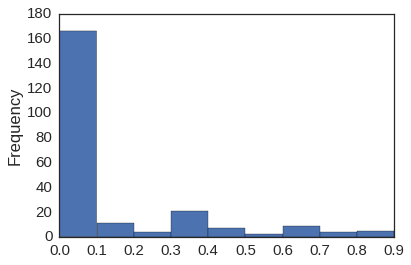

In [7]:
mdf['AS50'].plot(kind = 'hist', bins = np.arange(0, 1.0, 0.1))

In [8]:
import glob

def edit_distance(ideal, orig):
    
    return sum(i != o for i, o in zip(ideal, orig))


def parse_grna(gRNA):
    """Extract and normalize the length of the protospacer"""
    
    parts = gRNA.split('.')
    if len(parts[1]) == 3:
        direc = 'Forward'
        proto = parts[0][-20:]
    else:
        direc = 'Reverse'
        proto = parts[1][:20]
        
    if len(proto) < 20:
        proto = 'N'*(20-len(proto)) + proto
        
    return direc, proto

freq_files = glob.glob('results/FrequencyTables/*.xlsx')
ideals = []

lookup = mdf.groupby(['Citation', 'Name'])['gRNA'].first()

for f in freq_files:
    
    cit, name = f.split('/')[-1].split('.')[0].split('_')
    
    freqs = pd.read_excel(f)
    ideal_grna = ''.join(freqs.idxmax().values)
    
    try:
        orig_gRNA = lookup[int(cit)][name]
    except KeyError:
        try:
            name = name.replace('-', ' ')
            orig_gRNA = lookup[int(cit)][name]
        except:
            continue
            
    direc, orig_proto = parse_grna(orig_gRNA)
    if direc == 'Reverse':
        ideal_proto = ideal_grna[3:]
    else:
        ideal_proto = ideal_grna[:-3]
    
    ed = edit_distance(ideal_proto, orig_proto)

    ideals.append({'Citation': int(cit),
                   'Name': name,                   
                   'Edit Distance': ed})
    
    
ideal_df = pd.DataFrame(ideals)

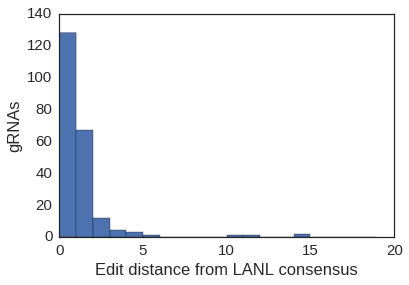

In [9]:
fig, ax = plt.subplots(1,1)
ideal_df['Edit Distance'].plot(kind='hist', 
                               bins = np.arange(0, 20, 1), 
                               ax=ax)
ax.set_ylabel('gRNAs')
ax.set_xlabel('Edit distance from LANL consensus')


In [10]:
(ideal_df['Edit Distance'] < 2).sum()

195

In [11]:
# This is the final form of Supplemental Table 1

mdf.to_excel('results/SupTable1.xlsx', index=False)